In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable as v
import scipy.special as scp
import random
from concurrent import futures
#import Exa_sol as ex
import time
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
is_gpu = torch.cuda.is_available()
if is_gpu:
    id = 0
    torch.cuda.set_device(id)
    
#gpu_nums = torch.cuda.device_count()
#gpu_index = torch.cuda.current_device()
#print(is_gpu,gpu_nums,gpu_index)
device = torch.device('cuda' if is_gpu else 'cpu')

#device = torch.device('cpu')
print(device)
torch.set_default_tensor_type('torch.FloatTensor')
print(torch.__version__)

import sys
sys.path.append('./Boundary2Solution_model')
sys.path.append('./Boundary2Solution_model/model')
import GenData as GD
import importlib
import MyUtils
import PointNetv1 as mynet1
import PointNetv2 as mynet2
import PointNetv3 as mynet3
import PointNetv3v2 as mynet4
import PointNet2v1andSelfAttention as mynet5
import IO 

from neuralop.models import FNO1d
operator = FNO1d(n_modes=(6, 6), hidden_channels=64,
                in_channels=3, out_channels=1, n_modes_height=6)


cuda
1.10.1


In [2]:
net_num = 2
if net_num == 1:
    net1 = mynet1.PointNet(3,1)
elif net_num == 2:
    net1 = mynet2.PointNet(3,1)
elif net_num == 4:
    net1 = mynet4.PointNet1(2,1,1)
elif net_num == 5:
    net1 = mynet5.PointNet()
elif net_num == 6:
    net1 = FNO1d(n_modes=(6, 6), hidden_channels=64,
                in_channels=3, out_channels=1, n_modes_height=6)
elif net_num == 7:
    net1 = PointNet2()

### smooth case

In [3]:
# 8000 samples, 7600 training samples and 400 test samples
from scipy.io import loadmat
x_train = torch.zeros(7600,2000,2)
r_train = torch.zeros(7600,2000,2)
normal_train = torch.zeros(7600,2000,2)
x_in_train = torch.zeros(7600,1000,2)
for i in range(5,9):
    for j in range(1900):
        data = loadmat(f'./smooth_data/5678/{i}/{j+1}.mat')
        x_train[(i - 5) * 1900 + j] = torch.tensor(data['x'])
        r_train[(i - 5) * 1900 + j] = torch.tensor(data['r'])
        normal_train[(i - 5) * 1900 + j] = torch.tensor(data['normal'])
        x_in_train[(i - 5) * 1900 + j] = torch.tensor(data['x_in'])
x_test = torch.zeros(400,2000,2)
r_test = torch.zeros(400,2000,2)
normal_test = torch.zeros(400,2000,2)
x_in_test = torch.zeros(400,1000,2)
for i in range(5,9):
    for j in range(100):
        data = loadmat(f'./smooth_data/5678/{i}/{j+1901}.mat')
        x_test[(i - 5) * 100 + j] = torch.tensor(data['x'])
        r_test[(i - 5) * 100 + j] = torch.tensor(data['r'])
        normal_test[(i - 5) * 100 + j] = torch.tensor(data['normal'])
        x_in_test[(i - 5) * 100 + j] = torch.tensor(data['x_in'])


In [25]:
# construct integral matrix
def G_bd_smooth1(x,h,normal):
    sample_num, N, _ = x.shape
    G2 = torch.zeros(sample_num,N,N)
    
    KP = torch.ones(N);
    KP[N-1] = KP[1] = 1 + 1.825748064736159e+00
    KP[N-2] = KP[2] = 1 - 1.325748064736159e+00
    
    j_index = np.array([j for j in range(N)])
    
    for p in (range(sample_num)):
        for i in range(N):
            r = x[p,:,:]-x[p,i,:]
            p_n = (h[p]*r*normal[p]).sum(axis=1)
            d = (np.sqrt(r[:,0]**2+r[:,1]**2))
            G2[p,i,:] = ( -1/(2*np.pi)*(p_n)/(d*d))*KP[j_index-i]
            G2[p,i,i] = -1/2
    return G2   
def G_bd_smooth(x,h,normal,device = torch.device('cpu')):
    sample_num, N, _ = x.shape
    G2 = torch.zeros(sample_num,N,N).to(device)
    
    KP = np.ones(N)
    KP[N-1] = KP[1] = 1 + 1.825748064736159e+00
    KP[N-2] = KP[2] = 1 - 1.325748064736159e+00
    
    j_index = np.array([j for j in range(N)])
    KP0 = torch.tensor(np.array([KP[(j_index-i)%N] for i in range(N)])).to(device)
    
    
    for p in (range(sample_num)):
        x1 = x[p,:,0]
        x2 = x[p,:,1]
        r1 = (x1 - x1[:,np.newaxis]).reshape(N,N,1)
        r2 = (x2 - x2[:,np.newaxis]).reshape(N,N,1)
        r = torch.cat((r1,r2),2)
        p_n = (h[p]*r*normal[p]).sum(axis=2)
        d = (torch.sqrt(r[:,:,0]**2+r[:,:,1]**2))
        G2[p,:,:] = ( -1/(2*np.pi)*(p_n)/(d*d))*KP0
        G2[p,j_index,j_index] = -1/2
    return G2 

def G_in_smooth(x, h, normal, x_in):
    sample_num, N, _ = x.shape
    _, N_in, _ = x_in.shape
    G2 = torch.zeros(sample_num,N_in,N)
    for p in range(sample_num):
        for i in range(N_in):
            r = x[p] - x_in[p,i]
            p_n = (h[p]*r*normal[p]).sum(axis=1)
            d = (np.sqrt(r[:,0]**2+r[:,1]**2))
            G2[p,i] = -1 / (2*np.pi) * (p_n)/(d*d)
    return G2

sample_num = 5
sample = np.random.randint(0,7600,sample_num)
x = x_train[sample]
r = r_train[sample]
h = (r**2).sum(axis=2).sqrt().reshape(sample_num,-1,1)
normal = normal_train[sample]
x_in = x_in_train[sample]
G20 = G_bd_smooth(x,h,normal)
G21 = G_bd_smooth1(x,h,normal)
u = (x[:,:,0]*x[:,:,1] + 2*x[:,:,0] + 3*x[:,:,1] + 1).reshape(sample_num, -1, 1)
u_in = x_in[:,:,0]*x_in[:,:,1] + 2*x_in[:,:,0] + 3*x_in[:,:,1] + 1
x0 = torch.cat((x,u),2)#.to(device)
G2 = G2#.to(device)
u = u#.to(device)



In [123]:
density_all = np.zeros((7600, 2000))
for i in tqdm(range(7600)):
    x = x_train[i:i+1]
    r = r_train[i:i+1]
    h = (r**2).sum(axis=2).sqrt().reshape(1,-1,1)
    normal = normal_train[i:i+1]
    G2 = G_bd_smooth(x,h,normal).squeeze()
    u = (x[:,:,0]*x[:,:,1] + 2*x[:,:,0] + 3*x[:,:,1] + 1).reshape(-1)
    density_all[i] = np.linalg.solve(G2.numpy(), u.numpy())


  1%|          | 79/7600 [00:48<1:16:55,  1.63it/s]


KeyboardInterrupt: 

In [109]:
## training
sample_num = 50
Epoch = 3000
optimzer1 = torch.optim.Adam(net1.parameters(net1),lr=0.0002)
loss_all = np.zeros(Epoch+1)
net1 = net1.to(device)
x0 = x0.to(device)

vertex_x = torch.zeros(sample_num,2,2)

for epoch in tqdm(range(Epoch)):
    
    # resampling
    if (epoch)%50==0:
        sample = np.random.randint(0,7600,sample_num)
        x = x_train[sample]
        r = r_train[sample]
        h = (r**2).sum(axis=2).sqrt().reshape(sample_num,-1,1)
        normal = normal_train[sample]
        G2 = G_bd_smooth(x,h,normal).to(device)
        mx = x.mean(axis=1)
        ux = x - mx[:,np.newaxis]
        u = (ux[:,:,0]*ux[:,:,1] + ux[:,:,0] + ux[:,:,1] + 1).reshape(sample_num, -1, 1)

        x0 = torch.cat((x,u),2).to(device)
        u = u.to(device)        
        
    loss = 0
    
    
    for i in range(sample_num):
        if net_num==1:
            x1 = (x0[i]).reshape(1,1,1000,3)
            density = net1(x1)[0][0]
        elif net_num==2:
            x1 = (x0[i]).reshape(2000,3,1)
            density = (net1(x1)).reshape(-1,1)
        
        G2_0 = G2[i]
        u0 = u[i]
        loss = loss + torch.mean(torch.pow((G2_0@density-u0),2))
    optimzer1.zero_grad()
    loss.backward()
    optimzer1.step()
    loss_all[epoch] = loss.cpu().detach().numpy() 
    
    #if epoch%200==0:
    #    save_variable(loss,'current_loss')

100%|██████████| 3000/3000 [14:58<00:00,  3.34it/s]


In [180]:

# another training method, supervised learning
density_all = np.load('./smooth_data/density/density1.npy')

sample_num = 64
Epoch = 2000
optimzer1 = torch.optim.Adam(net1.parameters(net1),lr=0.0002)
loss_all = np.zeros(Epoch+1)
net1 = net1.to(device)
x0 = x0.to(device)

vertex_x = torch.zeros(sample_num,2,2)

for epoch in tqdm(range(Epoch)):
    
    if (epoch)%50==0:
        sample = np.random.randint(0,1900,sample_num)
        x = x_train[sample]
        u = (x[:,:,0]*x[:,:,1] + 2*x[:,:,0] + 3*x[:,:,1] + 1).reshape(sample_num, -1, 1)
        x0 = torch.cat((x,u),2).to(device)
        density0 = torch.tensor(density_all[sample]).cuda()
        
    loss = 0
    
    for i in range(sample_num):
        if net_num==1:
            x1 = (x0[i]).reshape(1,1,1000,3)
            density = net1(x1)[0][0]
        elif net_num==2:
            x1 = (x0[i]).reshape(2000,3,1)
            density = (net1(x1)).reshape(-1)
        elif net_num == 7:
            
        loss = loss + torch.mean(torch.pow((density-density0[i]),2))
    optimzer1.zero_grad()
    loss.backward()
    optimzer1.step()
    loss_all[epoch] = loss.cpu().detach().numpy() 
    
    #if epoch%200==0:
    #    save_variable(loss,'current_loss')

100%|██████████| 2000/2000 [10:41<00:00,  3.12it/s]


In [107]:
sample_num = 2
sample = np.random.randint(0,10,sample_num)
sample = [i for i in range(sample_num)]
x = x_train[sample]
r = r_train[sample]
h = (r**2).sum(axis=2).sqrt().reshape(sample_num,-1,1)
normal = normal_train[sample]
x_in = x_in_train[sample]
G2 = G_in_smooth(x,h,normal,x_in)

mx = x.mean(axis=1)
ux = x - mx[:,np.newaxis]
u = (ux[:,:,0]*ux[:,:,1] + ux[:,:,0] + ux[:,:,1] + 1).reshape(sample_num, -1, 1)

ux_in = x_in - mx[:,np.newaxis]
u_in = (ux_in[:,:,0]*ux_in[:,:,1] + ux_in[:,:,0] + ux_in[:,:,1] + 1).reshape(sample_num, -1, 1)


x0 = torch.cat((x,u),2).to(device)
G2 = G2.to(device)
l2_er = np.zeros(sample_num)
for i in range(sample_num):
    density = net1(x0[i].reshape(2000,3,1)).reshape(-1,1)
    u0_in = (G2[i]@density).reshape(-1).cpu().detach()
    l2_er[i] = ((u_in[i].reshape(-1)-u0_in).norm()/(u_in[i].reshape(-1)).norm()).numpy()

In [128]:
from scipy import io
from scipy.io import loadmat

sample_num = 2800
train_data_x = np.zeros((sample_num,5,128,128))
train_data_y = np.zeros((sample_num,1,128,128))
normal_test0 = np.zeros((sample_num, 2000, 2))
tangent = np.zeros((sample_num, 2000, 2))
x_test0 = np.zeros((sample_num, 2000, 2))

u_bd = np.zeros((sample_num,2000))

iidx = [i for i in range(600)] + [1900 + i for i in range(600)] +\
    [3800 + i for i in range(600)] + [5700 + i for i in range(600)] +\
    [i for i in range(7600,8000)]
i = 0
for k in tqdm(iidx):
    data = loadmat(f'./FNO_test/FNO_data/fno_data_smooth/{k+1}.mat')
    position = data['fp']
    position = data['fd']>0.005
    
    train_data_x[i,0,:,:] = data['fx']  
    train_data_x[i,1,:,:] = data['fy']        
    train_data_x[i,2,:,:] = position
    #train_data_x[i,3,:,:] = data['fb']   
    train_data_x[i,4,:,:] = data['fd']
    normal_test0[i,:,:] = data['normal']
    tangent[i,:,:] = data['r']
    x_test0[i,:,:] = data['x']
    
    t = np.linspace(0,2*np.pi*(1-1/2000),2000)
    a1,a2,a3,a4 = np.random.rand(4)*2-1
    u_bd[i] = a1*np.sin(np.pi*t) + a2*np.sin(2*np.pi*t) + \
            a3*np.sin(3*np.pi*t) + a4*np.sin(4*np.pi*t)
    
    idx = data['fid']
    idx[idx<1] = idx[idx<1] + 1
    train_data_x[i,3,:,:] = u_bd[i][idx-1] * position
    i = i + 1
h_test0 = torch.tensor(np.sqrt((tangent**2).sum(axis=2)).reshape(sample_num,-1,1))
x_test0 = torch.tensor(x_test0)
normal_test0 = torch.tensor(normal_test0)
#G2 = G_bd_smooth(x, h, normal)


100%|██████████| 2800/2800 [00:08<00:00, 325.03it/s]


In [253]:
# test process

st , num = 2720,1
x1_sd = torch.tensor(train_data_x[0,0,:,:].reshape(1,-1))
x2_sd = torch.tensor(train_data_x[0,1,:,:].reshape(1,-1))
x_st = torch.cat((x1_sd,x2_sd),0).transpose(0,1)
l2_er = np.zeros(num)
for i0 in tqdm(range(st, st+num)):
    i = i0
    x = x_test0[i:i+1].float()
    h = h_test0[i:i+1].float()
    normal = normal_test0[i:i+1].float()
    pos = train_data_x[i,4,:,:].reshape(-1)
    x_in = x_st[pos>0.001].reshape(1,-1,2).float()
    G2 = G_in_smooth(x,h,normal,x_in)

    mx = x.mean(axis=1)
    ux = x - mx[:,np.newaxis]
    u = (ux[:,:,0]*ux[:,:,1] + ux[:,:,0] + ux[:,:,1] + 1).reshape(1, -1, 1)

    ux_in = x_in - mx[:,np.newaxis]
    u_in = (ux_in[:,:,0]*ux_in[:,:,1] + ux_in[:,:,0] + ux_in[:,:,1] + 1).reshape(1, -1, 1)

    x0 = torch.cat((x,u),2).to(device)
    G2 = G2.to(device)
    
    
    density = net1(x0[0].reshape(2000,3,1)).reshape(-1,1)
    u0_in = (G2[0]@density).reshape(-1).cpu().detach()
    l2_er[i-st] = ((u_in[0].reshape(-1)-u0_in).norm()/(u_in[0].reshape(-1)).norm()).numpy()


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


In [252]:
# print l2 error
np.mean(l2_er),l2_er

(0.021524176374077796,
 array([0.01457703, 0.02228476, 0.02162942, 0.01585028, 0.02522241,
        0.01684425, 0.01240205, 0.03010909, 0.01887632, 0.02006353,
        0.01332241, 0.02916192, 0.03522212, 0.03018752, 0.01572241,
        0.01047093, 0.02509981, 0.01138613, 0.0271899 , 0.03187835,
        0.01723174, 0.03168765, 0.02808164, 0.01590269, 0.01770003]))

In [127]:
sample_num = 25
sample = np.random.randint(400,500,sample_num)

x = x_test[sample]
r = r_test[sample]
h = (r**2).sum(axis=2).sqrt().reshape(sample_num,-1,1)
normal = normal_test0[sample]
x_in = x_in_test[sample]
G2 = G_in_smooth(x,h,normal,x_in)

mx = x.mean(axis=1)
ux = x - mx[:,np.newaxis]
u = (ux[:,:,0]*ux[:,:,1] + ux[:,:,0] + ux[:,:,1] + 1).reshape(sample_num, -1, 1)

ux_in = x_in - mx[:,np.newaxis]
u_in = (ux_in[:,:,0]*ux_in[:,:,1] + ux_in[:,:,0] + ux_in[:,:,1] + 1).reshape(sample_num, -1, 1)

x0 = torch.cat((x,u),2).to(device)
G2 = G2.to(device)
l2_er = np.zeros(sample_num)
for i in range(sample_num):
    density = net1(x0[i].reshape(2000,3,1)).reshape(-1,1)
    u0_in = (G2[i]@density).reshape(-1).cpu().detach()
    l2_er[i] = ((u_in[i].reshape(-1)-u0_in).norm()/(u_in[i].reshape(-1)).norm()).numpy()

IndexError: index 452 is out of bounds for dimension 0 with size 400

In [250]:
np.mean(l2_er),l2_er

(0.02414226805791259,
 array([0.00937541, 0.01378182, 0.01175915, 0.03382413, 0.02093924,
        0.07934065, 0.03163229, 0.03002285, 0.01315862, 0.01776612,
        0.02351773, 0.01085935, 0.09438502, 0.03830693, 0.00934535,
        0.03086432, 0.01023096, 0.00932941, 0.00648666, 0.01195244,
        0.03614592, 0.00730816, 0.02020383, 0.0186325 , 0.01438783]))

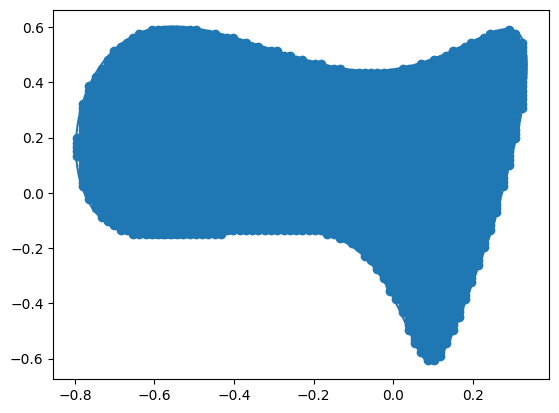

In [254]:
plt.plot(x[0,:,0],x[0,:,1])
plt.scatter(x_in[0,:,0], x_in[0,:,1])

smooth = {'x_bd':x[0].numpy(),'u_bd':u.squeeze().numpy(),
          'u_exa':u_in.squeeze().numpy(),'u_num':u0_in.numpy(), 'x_in':x_in.squeeze().numpy()}
io.savemat('./FNO_test/smooth4_1.mat', smooth)


## polygon case

In [8]:
# generating data
net_num = 2
if net_num == 1:
    net2 = mynet1.PointNet(3,1)
elif net_num == 2:
    net2 = mynet2.PointNet(3,1)
elif net_num == 4:
    net2 = mynet4.PointNet1(2,1,1)
elif net_num == 5:
    net2 = mynet5.PointNet()
elif net_num == 6:
    net2 = FNO1d(n_modes=(6, 6), hidden_channels=64,
                in_channels=3, out_channels=1, n_modes_height=6)    
problem_type = 'Poisson'
in_or_out = 'in'
a1 = b1 = 0.8
a2 = b2 = 0.2
ver_num = 8
N = 2000
polygon_num = 10
sol_type = np.zeros(polygon_num)+1
train = True
num_in = 0

vertex_x,x,G2,u,x_in,G2_in,u_in = GD.main(ver_num,N,polygon_num,sol_type,a1,a2,b1,b2,problem_type,in_or_out,train,num_in)

x0 = torch.cat((x,u),2).to(device)
net1 = net1.to(device)
G2 = G2.to(device)
u = u.to(device)

In [ ]:
## unsupervised learning
polygon_num = 50
net2 = net2.to(device)
Epoch = 2000
optimzer1 = torch.optim.Adam(net2.parameters(net2),lr=0.0001)
loss_all = np.zeros(Epoch+1)
num_in = 0
for epoch in tqdm(range(Epoch)):
    
    if (epoch)%50==0:
        #num = int(torch.rand(1)*10)
        sol_type = np.zeros(polygon_num)+1
        vertex_x,x,G2,u,x_in,G2_in,u_in = \
            GD.main(ver_num,N,polygon_num,sol_type,a1,a2,b1,b2,problem_type,in_or_out,train,num_in)        
        x0 = (torch.cat((x,u),2)).to(device)
        #dist = (x**2).sum(axis=2).reshape(polygon_num,-1,1)
        #polar = torch.atan(x[:,:,1]/x[:,:,0]).reshape(polygon_num,-1,1)
        
        #x_0, x_1 = x[:,:,0].reshape(polygon_num,-1,1), x[:,:,1].reshape(polygon_num,-1,1)
        #x0 = torch.cat((torch.cat((torch.cat((x0,dist),2),polar),2),torch.sin(np.pi*x_0)),2)
        #x0 = (torch.cat((x0,torch.sin(np.pi*x_1)),2)).to(device)
        G2 = G2.to(device)
        u = u.to(device)        
    
    loss = 0
    
    #for i in range(num*50,num*50+50):
    h = (net2(x0.transpose(1,2))).reshape(polygon_num,-1)
    for i in range(polygon_num):
        G2_0 = G2[i]
        u0 = u[i].reshape(-1)
        loss = loss + torch.mean(torch.pow((G2_0@h[i]-u0),2))

    optimzer1.zero_grad()
    loss.backward()
    optimzer1.step()
    loss_all[epoch] = loss.cpu().detach().numpy() 
    #if epoch%200==0:
    #    save_variable(loss,'current_loss')

 22%|██▏       | 449/2000 [03:10<01:49, 14.13it/s]  

In [157]:
polygon_in = 100
num_in = 1000
sol_type = np.zeros(polygon_in)+1
ver_num = 8
vertex_x,x,G2,u,x_in,G2_in,u_in = GD.main(ver_num,4000,polygon_in,sol_type,a1,a2,b1,b2,problem_type,in_or_out,train,num_in)
x0 = (torch.cat((x,u),2)).to(device)
l2_err =  np.zeros(polygon_in)

h = (net2(x0.transpose(1,2))).reshape(polygon_in,-1)
for i in range(polygon_in):
    G2_0 = G2_in[i].to(device)
    u0 = u_in[i].reshape(-1).to(device)
    u_num = -G2_0@h[i]
    l2_err[i] = ((u_num-u0).norm()/(u0).norm()).cpu().detach().numpy()
l2_err, np.mean(l2_err)        

(array([0.04879719, 0.01945317, 0.0147261 , 0.01777593, 0.01460506,
        0.01113595, 0.01494333, 0.01416154, 0.00928565, 0.02939475,
        0.02017271, 0.02439168, 0.0146599 , 0.01515962, 0.02050115,
        0.01625652, 0.02158539, 0.01437722, 0.01216432, 0.01177209,
        0.02227774, 0.01409088, 0.01980106, 0.00706597, 0.03324455,
        0.02955586, 0.01132545, 0.01062068, 0.07429172, 0.02137393,
        0.05817229, 0.01229747, 0.03656689, 0.01317772, 0.05996732,
        0.01835516, 0.022044  , 0.11908126, 0.01751392, 0.00959682,
        0.01540213, 0.02528696, 0.01920387, 0.01752998, 0.01352161,
        0.05400305, 0.01569828, 0.03896255, 0.01150967, 0.02362763,
        0.01178907, 0.01501991, 0.01356291, 0.03141765, 0.01123517,
        0.01778858, 0.04059872, 0.0076322 , 0.01666557, 0.03044499,
        0.01504677, 0.01179945, 0.0181369 , 0.01924353, 0.01311642,
        0.018497  , 0.01241668, 0.01604516, 0.02334618, 0.02152808,
        0.05060941, 0.02658637, 0.01172111, 0.01